# Cops and robber in a DAG

You are given a directed acyclic graph (DAG) $G$ with $n$ vertices and $m$ edges, a number $B$ and real vectors $x^{\text{max}}\in \mathbb{R}^m$, $a\in \mathbb{R}^m$. A robber wants to get from vertex 1 to vertex $n$. The cops want to prevent it, by assigning $x_e \in [0, x^{\text{max}}_e]$ of resources to every edge $e\in E(G)$. Then, the probability that the robber safely goes through any edge $e$ is $\exp(-a_ex_e)$, independently for every edge. Moreover, $B$ is the upper bound on the total amount of cops' resources, i.e., $\sum_e x_e \le B$. Find the assignment of resources that minimizes $p^\star$, where $p^\star$ is the maximum probability that the robber travels safely from 1 to $n$, over all paths in the DAG. Compare $p^\star$ with the probability obtained for the uniform distribution of police's resources.

(This exercise is inspired by the collection *Additional Exercises for Convex Optimization* by Boyd and Vandenberghe, used under permission.)

In [47]:
import numpy as np

In [48]:
np.random.seed(123)
n = 10
m = 20
B = m / 2
edges = np.array([[1,1,1,2,2,2,3,3,4,4,5,5,6,6,7,7,8,7,8,9],[2,3,4,6,3,4,5,6,6,7,8,7,7,8,8,9,9,10,10,10]]).T-1
edges

array([[0, 1],
       [0, 2],
       [0, 3],
       [1, 5],
       [1, 2],
       [1, 3],
       [2, 4],
       [2, 5],
       [3, 5],
       [3, 6],
       [4, 7],
       [4, 6],
       [5, 6],
       [5, 7],
       [6, 7],
       [6, 8],
       [7, 8],
       [6, 9],
       [7, 9],
       [8, 9]])

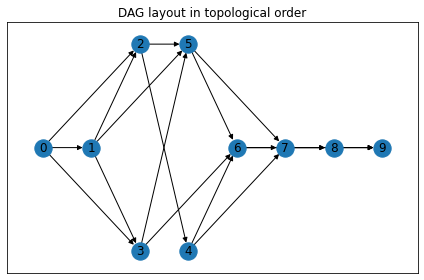

In [49]:
import networkx as nx
from matplotlib import pyplot as plt
G = nx.DiGraph()
G.add_edges_from(edges)

for layer, nodes in enumerate(nx.topological_generations(G)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        G.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(G, subset_key="layer")

fig, ax = plt.subplots()
nx.draw_networkx(G, pos=pos, ax=ax)
ax.set_title("DAG layout in topological order")
fig.tight_layout()
plt.show()

In [50]:
a = 2 * np.random.rand(m)
x_max = 1 + np.random.rand(m)
x_max

array([1.63440096, 1.84943179, 1.72445532, 1.61102351, 1.72244338,
       1.32295891, 1.36178866, 1.22826323, 1.29371405, 1.63097612,
       1.09210494, 1.43370117, 1.43086276, 1.4936851 , 1.42583029,
       1.31226122, 1.42635131, 1.89338916, 1.94416002, 1.50183668])

In [51]:
topological_order = np.array(list(nx.topological_sort(G)))
topological_order

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [52]:
import gurobipy as gp
from gurobipy import GRB


model = gp.Model("Cops-and-robber")


x = {}
for i in range(m):
    x[i] = model.addVar(ub=x_max[i], name=f"x_({i})")


v = {}
v[0] = 0 # log(1) = 0
for i in range(1,n):
    v[i] = model.addVar(lb=-GRB.INFINITY ,name=f"v_{i}")


model.addConstr(gp.quicksum(x[i] for i in range(m)) <= B)
model.addConstrs( v[edges[i][1]] >= -a[i] * x[i] + v[edges[i][0]] for i in range(m))


model.setObjective(v[n-1], GRB.MINIMIZE)


model.optimize()
print(f"Final probability {np.exp(v[n-1].X)}")

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21 rows, 29 columns and 77 nonzeros
Model fingerprint: 0xe344b437
Coefficient statistics:
  Matrix range     [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+01, 1e+01]
Presolve removed 8 rows and 3 columns
Presolve time: 0.00s
Presolved: 13 rows, 26 columns, 85 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      15   -2.2950812e+00   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective -2.295081233e+00
Final probability 0.1007532084823226


Uniform distribution of police's recources.

In [70]:
x_uni = {}
v_uni = {}

for i in range(m):
    x_uni[i] = B/m

for i in range(n):
    v_uni[i] = 0


for i in range(m):
    v_uni[edges[i][1]] = max(v_uni[edges[i][1]], np.exp(-a[i] * x_uni[i]) * v_uni[edges[i][0]])

print(f"Uniform probability {v_uni[n-1]}")

Uniform probability 0
